In [216]:
# Import standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime
import pickle
%matplotlib inline

# Import data preparation libraries
from matplotlib.cbook import boxplot_stats  
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.utils import resample

# Import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE 

<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;">  1. Import and explore data:

In [217]:
data_raw = pd.read_csv('signal-data.csv')
print(data_raw.size)
print(data_raw.shape)

927664
(1567, 592)


In [218]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB


In [219]:
data_raw.dtypes

Time          object
0            float64
1            float64
2            float64
3            float64
              ...   
586          float64
587          float64
588          float64
589          float64
Pass/Fail      int64
Length: 592, dtype: object

- There are 590 columns of float64 datatype, 1 column titled 'Pass/Fail' of int64 datatype and 1 time series object.
- Since it is given that several of these features are just noise, we try to identify the critical features before applying the machine learning algorithms.

In [220]:
data_raw.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [221]:
data_raw.nunique()

Time         1534
0            1520
1            1504
2             507
3             518
             ... 
586           322
587           260
588           120
589           611
Pass/Fail       2
Length: 592, dtype: int64

In [222]:
data_raw.isna().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

In [223]:
data_raw.isnull().sum()

Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64

- Null values will be imputed in the next step.

<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;">  2. Data cleansing

In [1]:
time_data = data_raw['Time']
data_raw = data_raw.drop(['Time'],axis=1)

NameError: name 'data_raw' is not defined

In [225]:
len(data_raw.columns[data_raw.isna().mean()>0.50])

28

- We observed that atleast 50% of the data is missing in 28 columns.
- We remove this columns in the next step.

In [226]:
drop_missing_val_cols = data_raw.columns[data_raw.isna().mean()>=0.50]
print(drop_missing_val_cols)
data_raw = data_raw.drop(drop_missing_val_cols,axis=1)

Index(['72', '73', '85', '109', '110', '111', '157', '158', '220', '244',
       '245', '246', '292', '293', '345', '346', '358', '382', '383', '384',
       '492', '516', '517', '518', '578', '579', '580', '581'],
      dtype='object')


In [227]:
data_raw.shape

(1567, 563)

- We reduced to 563 features by dropping 28 columns in which atleast 50% of the data is missing.

In [228]:
# Impute the null values using the median values in the respective column
columns = data_raw.columns
imputer = SimpleImputer(missing_values = np.nan, strategy ='median',copy=False)
data_raw = pd.DataFrame(imputer.fit_transform(data_raw))
data_raw.columns = columns

In [229]:
# We replace class represntation of pass category with '1' and the fail category with '0'
data_raw['Pass/Fail'] = data_raw['Pass/Fail'].replace(1,0)
data_raw['Pass/Fail'] = data_raw['Pass/Fail'].replace(-1,1)

In [230]:
data_raw['Pass/Fail'].value_counts()

1.0    1463
0.0     104
Name: Pass/Fail, dtype: int64

<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;">  3. Data analysis & visualization

In [231]:
# Statistical analysis of the data
data_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,1567.0,3014.441551,73.480841,2743.2400,2966.66500,3011.4900,3056.5400,3356.3500
1,1567.0,2495.866110,80.228143,2158.7500,2452.88500,2499.4050,2538.7450,2846.4400
2,1567.0,2200.551958,29.380973,2060.6600,2181.09995,2201.0667,2218.0555,2315.2667
3,1567.0,1395.383474,439.837330,0.0000,1083.88580,1285.2144,1590.1699,3715.0417
4,1567.0,4.171281,56.103721,0.6815,1.01770,1.3168,1.5188,1114.5366
...,...,...,...,...,...,...,...,...
586,1567.0,0.021458,0.012354,-0.0169,0.01345,0.0205,0.0276,0.1028
587,1567.0,0.016474,0.008805,0.0032,0.01060,0.0148,0.0203,0.0799
588,1567.0,0.005283,0.002866,0.0010,0.00330,0.0046,0.0064,0.0286
589,1567.0,99.652345,93.864558,0.0000,44.36860,71.9005,114.7497,737.3048


In [232]:
np.sum(data_raw.describe().transpose()['min'].values==data_raw.describe().transpose()['max'].values)

116

- We observe that 116 columns have constant data.
- We drop these columns as there is no variance in the data.

In [233]:
drop_constant_values_cols = data_raw.describe().transpose()[data_raw.describe().transpose()['min'].values==data_raw.describe().transpose()['max'].values].index

In [234]:
drop_constant_values_cols

Index(['5', '13', '42', '49', '52', '69', '97', '141', '149', '178',
       ...
       '529', '530', '531', '532', '533', '534', '535', '536', '537', '538'],
      dtype='object', length=116)

In [235]:
data_raw=data_raw.drop(drop_constant_values_cols,axis=1)

In [236]:
data_raw.shape

(1567, 447)

- Now we came down to 447 features.

In [237]:
#data_raw.corr().style.background_gradient(cmap='BuGn')

- In the next step, we identify the highly correlated features and drop the corresponding columns.
- We define the highly correlated features as the ones that have correlation coefficient greater than 0.7

In [238]:
corr_mat = data_raw.corr()

In [239]:
threshold = 0.7
drop_corr_cols = [(corr_mat.columns.values[j]) for j in range(len(corr_mat.columns)-1) for i in range(len(corr_mat.index.values)-1) if i!=j and corr_mat.iloc[i,j]>threshold]

In [240]:
drop_corr_cols = set(drop_corr_cols)
len(drop_corr_cols)

330

- We observe that 330 columns are highly correlated with the rest of the columns.

In [241]:
data_raw=data_raw.drop(drop_corr_cols,axis=1)
data_raw.head()

,0,1,2,3,6,7,8,9,10,12,...,548,558,562,563,570,571,582,586,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,97.6133,0.1242,1.5005,0.0162,-0.0034,202.4396,...,75.752,1.0344,264.272,0.6510,533.8500,2.1113,0.5005,0.0205,71.9005,1.0
1,3095.78,2465.14,2230.4222,1463.6606,102.3433,0.1247,1.4966,-0.0005,-0.0148,200.5470,...,74.640,0.9634,264.272,0.6510,535.0164,2.4335,0.5019,0.0096,208.2045,1.0
2,2932.61,2559.94,2186.4111,1698.0172,95.4878,0.1241,1.4436,0.0041,0.0013,202.0179,...,74.654,1.5021,267.064,0.9032,535.0245,2.0293,0.4958,0.0584,82.8602,0.0
3,2988.72,2479.90,2199.0333,909.7926,104.2367,0.1217,1.4882,-0.0124,-0.0033,201.8482,...,72.442,1.1613,268.228,0.6511,530.5682,2.0253,0.4990,0.0202,73.8432,1.0
4,3032.24,2502.87,2233.3667,1326.5200,100.3967,0.1235,1.5031,-0.0031,-0.0072,201.9424,...,79.156,0.9778,264.272,0.6510,532.0155,2.0275,0.4800,0.0202,73.8432,1.0


In [242]:
data_raw.shape

(1567, 117)

- We identified 117 critical features at this stage.

In [243]:
# We process the time series data in this step
data_raw['Time'] = time_data

data_raw['year'] = pd.DatetimeIndex(data_raw['Time']).year
data_raw['month'] = pd.DatetimeIndex(data_raw['Time']).month
data_raw['date'] = pd.DatetimeIndex(data_raw['Time']).day
data_raw['week_day'] = pd.DatetimeIndex(data_raw['Time']).weekday
data_raw['hour'] = pd.DatetimeIndex(data_raw['Time']).hour
data_raw['min'] = pd.DatetimeIndex(data_raw['Time']).minute

In [244]:
data_raw = data_raw.drop(['Time'],axis=1)

In [245]:
data_raw.head()

,0,1,2,3,6,7,8,9,10,12,...,582,586,589,Pass/Fail,year,month,date,week_day,hour,min
0,3030.93,2564.00,2187.7333,1411.1265,97.6133,0.1242,1.5005,0.0162,-0.0034,202.4396,...,0.5005,0.0205,71.9005,1.0,2008,7,19,5,11,55
1,3095.78,2465.14,2230.4222,1463.6606,102.3433,0.1247,1.4966,-0.0005,-0.0148,200.5470,...,0.5019,0.0096,208.2045,1.0,2008,7,19,5,12,32
2,2932.61,2559.94,2186.4111,1698.0172,95.4878,0.1241,1.4436,0.0041,0.0013,202.0179,...,0.4958,0.0584,82.8602,0.0,2008,7,19,5,13,17
3,2988.72,2479.90,2199.0333,909.7926,104.2367,0.1217,1.4882,-0.0124,-0.0033,201.8482,...,0.4990,0.0202,73.8432,1.0,2008,7,19,5,14,43
4,3032.24,2502.87,2233.3667,1326.5200,100.3967,0.1235,1.5031,-0.0031,-0.0072,201.9424,...,0.4800,0.0202,73.8432,1.0,2008,7,19,5,15,22


In [246]:
data_raw['year'].unique()

array([2008], dtype=int64)

In [247]:
data_raw['month'].unique()

array([ 7,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12], dtype=int64)

In [248]:
data_raw['date'].unique()

array([19, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31,  8, 13, 15, 16, 17, 18,
       24,  9, 14, 26, 10], dtype=int64)

In [249]:
data_raw['week_day'].unique()

array([5, 6, 0, 1, 2, 4, 3], dtype=int64)

In [250]:
data_raw['hour'].unique()

array([11, 12, 13, 14, 15, 17, 19, 20, 21, 22,  3,  8,  0,  2,  5,  4,  9,
       16, 23,  6, 18,  7, 10,  1], dtype=int64)

In [251]:
data_raw['min'].unique()

array([55, 32, 17, 43, 22, 53, 44, 45, 24, 35, 57, 52, 21,  3, 59, 41, 47,
        0, 30, 15, 23, 18, 37, 10, 46,  6, 49, 28, 14, 31, 48, 36, 11,  8,
       16, 19,  5,  7,  2, 29, 20, 26, 39,  9, 25, 27, 58,  4, 51, 33, 12,
       54, 50, 38, 40, 56, 34, 13, 42,  1], dtype=int64)

- We observe that the given data corresponds to all the months of the year 2008, so we can drop this column.
- It also seems that the data is not collected in the first week of every month.
- However, the data is collected on all the days of the weeks of collection.

In [252]:
data_raw = data_raw.drop(['year'],axis=1)
data_raw.columns.values

array(['0', '1', '2', '3', '6', '7', '8', '9', '10', '12', '14', '15',
       '18', '19', '20', '21', '22', '23', '24', '28', '31', '33', '36',
       '37', '38', '40', '41', '44', '48', '55', '56', '57', '58', '59',
       '61', '63', '68', '71', '75', '76', '77', '78', '79', '80', '81',
       '82', '83', '84', '86', '87', '88', '90', '91', '92', '93', '95',
       '96', '99', '100', '102', '103', '104', '105', '106', '107', '108',
       '112', '113', '115', '116', '118', '119', '120', '126', '128',
       '129', '130', '131', '132', '133', '134', '418', '419', '423',
       '432', '433', '438', '460', '468', '472', '476', '482', '483',
       '484', '485', '486', '487', '488', '489', '499', '500', '510',
       '511', '521', '542', '544', '547', '548', '558', '562', '563',
       '570', '571', '582', '586', '589', 'Pass/Fail', 'month', 'date',
       'week_day', 'hour', 'min'], dtype=object)

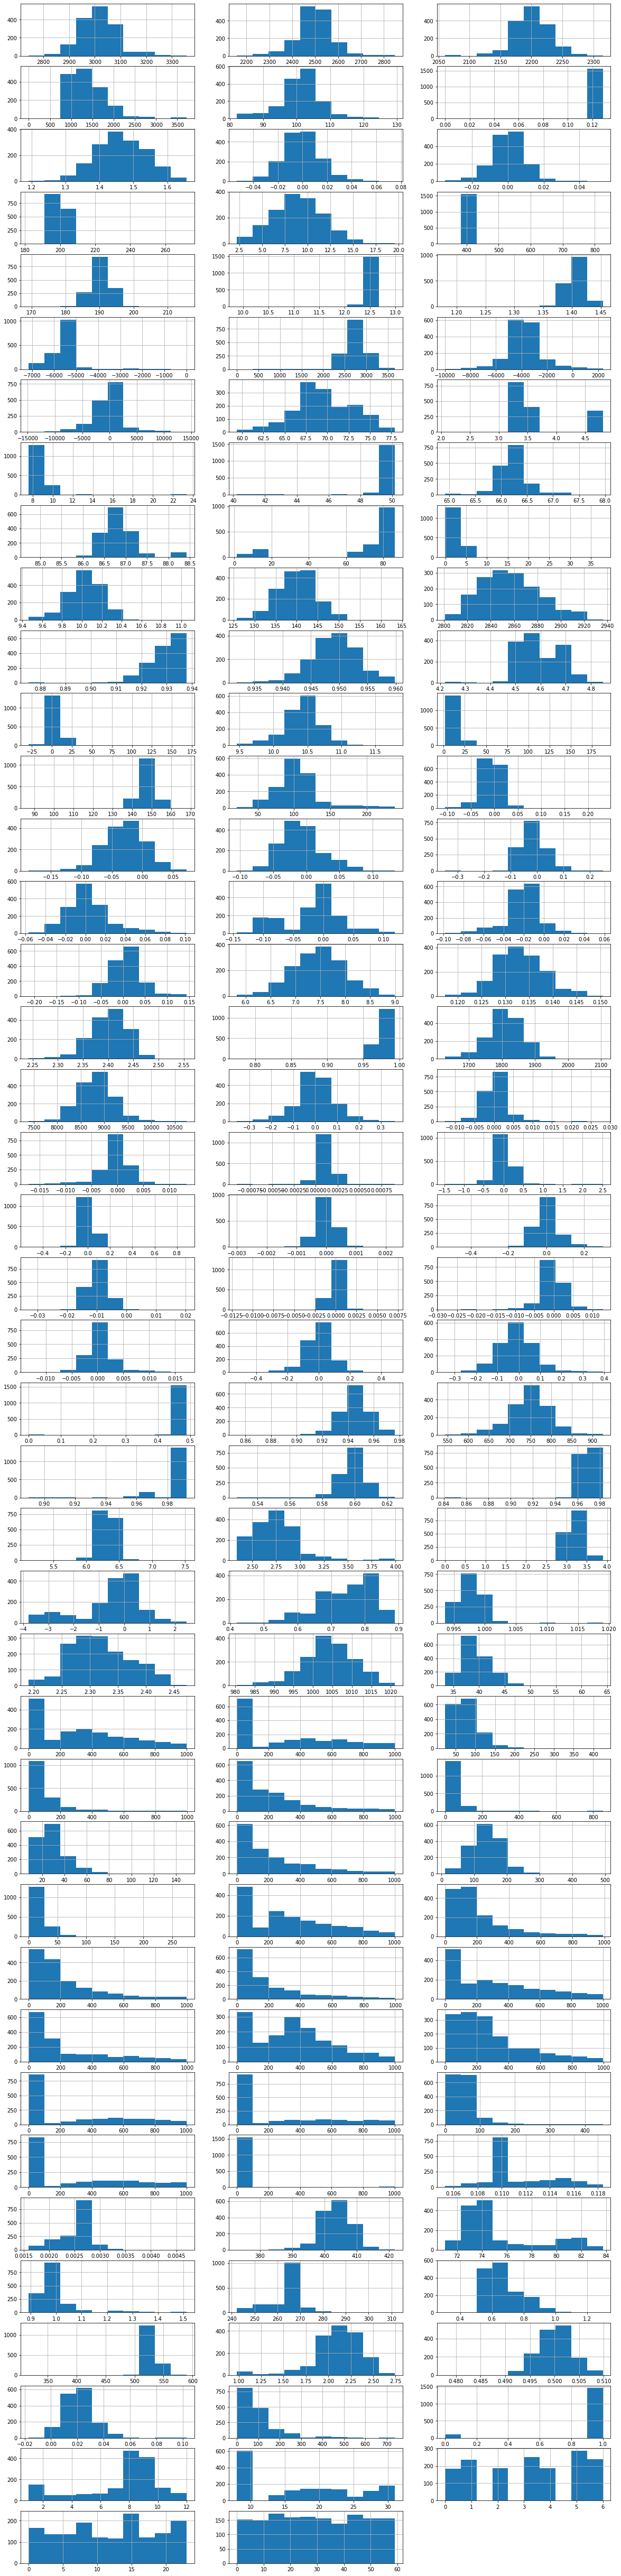

In [253]:
fig=plt.figure(figsize=(20,100))
[data_raw[data_raw.columns.values[i]].hist(bins=10,ax=fig.add_subplot(46,3,(i+1))) for i in range(0,data_raw.shape[1])];

Observations:
   - there is very low standard deviation in several features,
   - there are significant outliers outside both 25% and 75% qurantiles, i,e., the data is both left and right skewed,
   - very few features are normally distributed.
   
Mitigating measures:
   - drop the features if the standard deviation is less than 0.3,
   - identify the outliers and replace them with mean values.

In [254]:
# Drop the features based on low standard deviation
data_raw = data_raw.drop(data_raw.iloc[:,:-7].std()[data_raw.iloc[:,:-7].std() < 0.3].index.values, axis=1)
data_raw.head()

,0,1,2,3,6,12,14,15,18,21,...,548,562,570,589,Pass/Fail,month,date,week_day,hour,min
0,3030.93,2564.00,2187.7333,1411.1265,97.6133,202.4396,7.9558,414.8710,192.3963,-5419.00,...,75.752,264.272,533.8500,71.9005,1.0,7,19,5,11,55
1,3095.78,2465.14,2230.4222,1463.6606,102.3433,200.5470,10.1548,414.7347,191.2872,-5441.50,...,74.640,264.272,535.0164,208.2045,1.0,7,19,5,12,32
2,2932.61,2559.94,2186.4111,1698.0172,95.4878,202.0179,9.5157,416.7075,192.7035,-5447.75,...,74.654,267.064,535.0245,82.8602,0.0,7,19,5,13,17
3,2988.72,2479.90,2199.0333,909.7926,104.2367,201.8482,9.6052,422.2894,192.1557,-5468.25,...,72.442,268.228,530.5682,73.8432,1.0,7,19,5,14,43
4,3032.24,2502.87,2233.3667,1326.5200,100.3967,201.9424,10.5661,420.5925,191.6037,-5476.25,...,79.156,264.272,532.0155,73.8432,1.0,7,19,5,15,22


In [255]:
data_raw.shape

(1567, 68)

- We finally identified 68 critical columns which we will use for the machine learning process in the next step.

In [256]:
data_raw.head()

,0,1,2,3,6,12,14,15,18,21,...,548,562,570,589,Pass/Fail,month,date,week_day,hour,min
0,3030.93,2564.00,2187.7333,1411.1265,97.6133,202.4396,7.9558,414.8710,192.3963,-5419.00,...,75.752,264.272,533.8500,71.9005,1.0,7,19,5,11,55
1,3095.78,2465.14,2230.4222,1463.6606,102.3433,200.5470,10.1548,414.7347,191.2872,-5441.50,...,74.640,264.272,535.0164,208.2045,1.0,7,19,5,12,32
2,2932.61,2559.94,2186.4111,1698.0172,95.4878,202.0179,9.5157,416.7075,192.7035,-5447.75,...,74.654,267.064,535.0245,82.8602,0.0,7,19,5,13,17
3,2988.72,2479.90,2199.0333,909.7926,104.2367,201.8482,9.6052,422.2894,192.1557,-5468.25,...,72.442,268.228,530.5682,73.8432,1.0,7,19,5,14,43
4,3032.24,2502.87,2233.3667,1326.5200,100.3967,201.9424,10.5661,420.5925,191.6037,-5476.25,...,79.156,264.272,532.0155,73.8432,1.0,7,19,5,15,22


In [257]:
# Replace the outliers with the mean values
Q1 = data_raw.quantile(0.25)
Q3 = data_raw.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0            89.87500
1            85.86000
2            36.95555
3           506.28410
6             6.59220
              ...    
month         2.00000
date         13.00000
week_day      4.00000
hour         12.00000
min          30.00000
Length: 68, dtype: float64


In [258]:
data_raw[~((data_raw < (Q1 - 1.5 * IQR)) | (data_raw > (Q3 + 1.5 * IQR))).any(axis=1)].shape

(70, 68)

- We observe that 70 rows have outlier in atleast 1 feature.

In [259]:
means = data_raw.describe().loc['mean',:].values

In [260]:
for j in range(len(data_raw.columns)-7):
    for i in range(len(data_raw.index)-7):
        if ((data_raw.iloc[i,j] < (Q1.iloc[j] - 1.5 * IQR.iloc[j])) | (data_raw.iloc[i,j] > (Q3.iloc[j] + 1.5 * IQR.iloc[j]))):
            data_raw.iloc[i,j] = means[j]

In [261]:
data_raw

,0,1,2,3,6,12,14,15,18,21,...,548,562,570,589,Pass/Fail,month,date,week_day,hour,min
0,3030.93,2564.00,2187.7333,1411.1265,97.6133,202.4396,7.9558,414.8710,192.3963,-5419.00,...,75.752,264.272,533.8500,71.9005,1.0,7,19,5,11,55
1,3095.78,2465.14,2230.4222,1463.6606,102.3433,200.5470,10.1548,414.7347,191.2872,-5441.50,...,74.640,264.272,535.0164,208.2045,1.0,7,19,5,12,32
2,2932.61,2559.94,2186.4111,1698.0172,95.4878,202.0179,9.5157,416.7075,192.7035,-5447.75,...,74.654,267.064,535.0245,82.8602,0.0,7,19,5,13,17
3,2988.72,2479.90,2199.0333,909.7926,104.2367,201.8482,9.6052,422.2894,192.1557,-5468.25,...,72.442,268.228,530.5682,73.8432,1.0,7,19,5,14,43
4,3032.24,2502.87,2233.3667,1326.5200,100.3967,201.9424,10.5661,420.5925,191.6037,-5476.25,...,79.156,264.272,532.0155,73.8432,1.0,7,19,5,15,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2899.41,2464.36,2179.7333,3085.3781,82.2467,203.9867,11.7692,419.3404,193.7470,-5418.75,...,77.166,264.272,536.3418,203.1720,1.0,10,16,3,15,13
1563,3052.31,2522.55,2198.5667,1124.6595,98.4689,204.0173,9.1620,405.8178,193.7889,-6408.75,...,73.254,266.832,537.9264,203.1720,1.0,10,16,3,20,49
1564,2978.81,2379.78,2206.3000,1110.4967,99.4122,199.5356,8.9670,412.2191,189.6642,-5153.25,...,74.156,256.730,530.3709,43.5231,1.0,10,17,4,5,26
1565,2894.92,2532.01,2177.0333,1183.7287,98.7978,197.2448,9.7354,401.9153,187.3818,-5271.75,...,73.254,264.272,534.3936,93.4941,1.0,10,17,4,6,1


(0, 100)

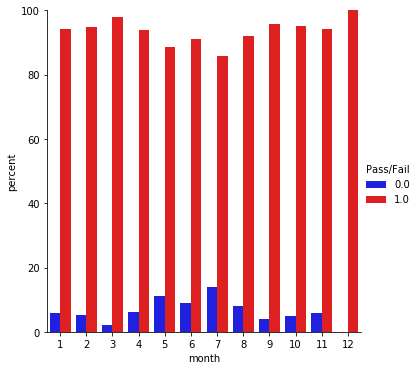

In [262]:
month_pass_fail = data_raw.groupby('month')['Pass/Fail'].value_counts(normalize=True)
month_pass_fail = month_pass_fail.mul(100)
month_pass_fail = month_pass_fail.rename('percent').reset_index()

g = sns.catplot(x='month',y='percent',hue='Pass/Fail',kind='bar',data=month_pass_fail,palette=['b','r'])
g.ax.set_ylim(0,100)

In [263]:
data_raw['month'].unique()

array([ 7,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12], dtype=int64)

(0, 100)

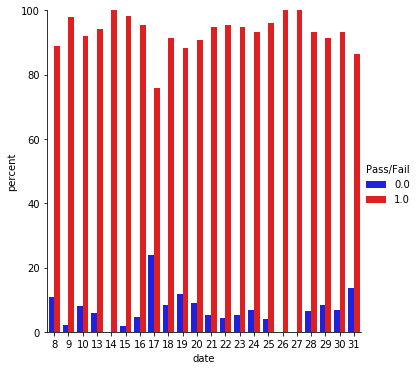

In [264]:
date_pass_fail = data_raw.groupby('date')['Pass/Fail'].value_counts(normalize=True)
date_pass_fail = date_pass_fail.mul(100)
date_pass_fail = date_pass_fail.rename('percent').reset_index()

g = sns.catplot(x='date',y='percent',hue='Pass/Fail',kind='bar',data=date_pass_fail,palette=['b','r'])
g.ax.set_ylim(0,100)

(0, 100)

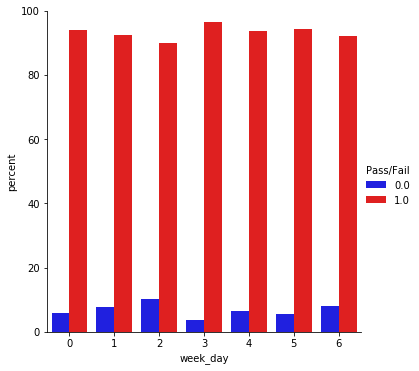

In [265]:
week_day_pass_fail = data_raw.groupby('week_day')['Pass/Fail'].value_counts(normalize=True)
week_day_pass_fail = week_day_pass_fail.mul(100)
week_day_pass_fail = week_day_pass_fail.rename('percent').reset_index()

g = sns.catplot(x='week_day',y='percent',hue='Pass/Fail',kind='bar',data=week_day_pass_fail,palette=['b','r'])
g.ax.set_ylim(0,100)

(0, 100)

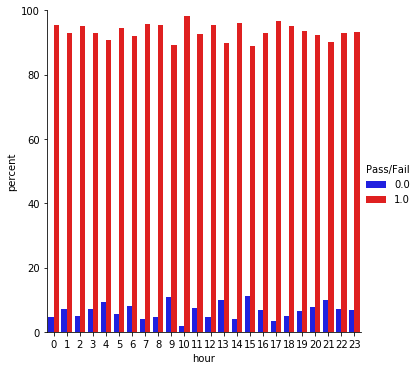

In [266]:
hour_pass_fail = data_raw.groupby('hour')['Pass/Fail'].value_counts(normalize=True)
hour_pass_fail = hour_pass_fail.mul(100)
hour_pass_fail = hour_pass_fail.rename('percent').reset_index()

g = sns.catplot(x='hour',y='percent',hue='Pass/Fail',kind='bar',data=hour_pass_fail,palette=['b','r'])
g.ax.set_ylim(0,100)

We observed that more observations in the failed category recored in:
   - the months of May, June, July and August,
   - during the middle of every month; exceptionally high on 17th of every month,
   - marginally in the middle of every week.   

<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;">  4. Data pre-processing

In [267]:
# Segregate predictors vs target attributes
X = data_raw.drop(['Pass/Fail',],axis=1)
X.head()

,0,1,2,3,6,12,14,15,18,21,...,547,548,562,570,589,month,date,week_day,hour,min
0,3030.93,2564.00,2187.7333,1411.1265,97.6133,202.4396,7.9558,414.8710,192.3963,-5419.00,...,395.570000,75.752,264.272,533.8500,71.9005,7,19,5,11,55
1,3095.78,2465.14,2230.4222,1463.6606,102.3433,200.5470,10.1548,414.7347,191.2872,-5441.50,...,408.798000,74.640,264.272,535.0164,208.2045,7,19,5,12,32
2,2932.61,2559.94,2186.4111,1698.0172,95.4878,202.0179,9.5157,416.7075,192.7035,-5447.75,...,411.136000,74.654,267.064,535.0245,82.8602,7,19,5,13,17
3,2988.72,2479.90,2199.0333,909.7926,104.2367,201.8482,9.6052,422.2894,192.1557,-5468.25,...,403.476047,72.442,268.228,530.5682,73.8432,7,19,5,14,43
4,3032.24,2502.87,2233.3667,1326.5200,100.3967,201.9424,10.5661,420.5925,191.6037,-5476.25,...,399.914000,79.156,264.272,532.0155,73.8432,7,19,5,15,22


In [268]:
y = data_raw['Pass/Fail']
y

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
1562    1.0
1563    1.0
1564    1.0
1565    1.0
1566    1.0
Name: Pass/Fail, Length: 1567, dtype: float64

In [269]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [270]:
# Check if the target column is well balanced
y_train.value_counts(normalize='True')

1.0    0.928832
0.0    0.071168
Name: Pass/Fail, dtype: float64

- We observe that there is significant imbalance in the target column.
- This will be corrected in the later section.

In [271]:
# Check the statistics of the training data
x_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,1096.0,3010.148900,60.851670,2831.9100,2970.100000,3012.830000,3051.500000,3190.7800
1,1096.0,2495.800510,58.019245,2326.5900,2459.807500,2495.866110,2531.787500,2664.5200
2,1096.0,2200.754461,25.873672,2126.6555,2183.311100,2200.551958,2216.874975,2270.2556
3,1096.0,1347.879789,341.412766,711.0258,1079.496700,1284.325600,1552.099975,3085.3781
6,1096.0,101.336990,4.591713,82.2467,98.777475,101.457800,104.198900,113.8833
...,...,...,...,...,...,...,...,...
month,1096.0,7.375000,2.595900,1.0000,6.000000,8.000000,9.000000,12.0000
date,1096.0,16.929745,7.544425,8.0000,10.000000,16.000000,22.000000,31.0000
week_day,1096.0,3.159672,1.980512,0.0000,1.000000,3.000000,5.000000,6.0000
hour,1096.0,11.836679,7.015167,0.0000,6.000000,12.000000,18.000000,23.0000


In [272]:
# Check the statistics of the testing data
x_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,471.0,3009.387480,64.725847,2770.4000,2966.66500,3011.320000,3052.83500,3190.9700
1,471.0,2499.232692,63.050587,2327.2900,2460.03000,2499.350000,2539.48500,2666.0400
2,471.0,2201.564185,25.246780,2127.9555,2181.17220,2201.588900,2218.62780,2270.2556
3,471.0,1358.497117,340.243391,812.1294,1101.97975,1298.820700,1553.31580,2914.1792
6,471.0,101.467458,4.379920,85.1011,98.89000,101.116476,104.23055,112.5811
...,...,...,...,...,...,...,...,...
month,471.0,7.490446,2.456302,1.0000,7.00000,8.000000,9.00000,12.0000
date,471.0,17.991507,7.729739,8.0000,10.00000,18.000000,25.00000,31.0000
week_day,471.0,3.199575,2.009149,0.0000,1.00000,3.000000,5.00000,6.0000
hour,471.0,11.649682,6.562822,0.0000,6.00000,12.000000,17.00000,23.0000


In [273]:
data_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,1567.0,3009.920037,62.021755,2770.4000,2968.0400,3012.18000,3051.8400,3190.9700
1,1567.0,2496.832136,59.576692,2326.5900,2459.8700,2495.86611,2534.3250,2666.0400
2,1567.0,2200.997843,25.681494,2126.6555,2183.0556,2200.95560,2217.5778,2270.2556
3,1567.0,1351.071085,340.987862,711.0258,1084.3779,1285.21440,1553.3158,3085.3781
6,1567.0,101.376205,4.528097,82.2467,98.7911,101.35560,104.1989,113.8833
...,...,...,...,...,...,...,...,...
month,1567.0,7.409700,2.554511,1.0000,7.0000,8.00000,9.0000,12.0000
date,1567.0,17.248883,7.613716,8.0000,10.0000,17.00000,23.0000,31.0000
week_day,1567.0,3.171666,1.988605,0.0000,1.0000,3.00000,5.0000,6.0000
hour,1567.0,11.780472,6.880780,0.0000,6.0000,12.00000,18.0000,23.0000


- We observe that the statistical characteristics of the training data, testing data and the raw data are quite similar.

In [274]:
# Perform scaling on the traing and the testing data
x_train = x_train.apply(zscore)
x_test  = x_test.apply(zscore)

<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;">  5. Model training, testing and tuning

- Firstly, we use Logistic Regression model for the classification purpose.
- Later, we also compare the results with RandomForest classifier and XG boost mrthods.

Classification accuracy of the train data : 0.927007299270073
Classification accuracy of the test data : 0.9278131634819533

Classification report:
              precision    recall  f1-score   support

         0.0       0.17      0.08      0.11        26
         1.0       0.95      0.98      0.96       445

    accuracy                           0.93       471
   macro avg       0.56      0.53      0.53       471
weighted avg       0.90      0.93      0.92       471



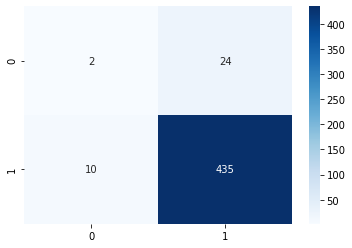

In [275]:
model_lr = LogisticRegression(solver="liblinear")
model_lr.fit(x_train, y_train)

y_predict = model_lr.predict(x_test)

print('Classification accuracy of the train data :',model_lr.score(x_train, y_train))
print('Classification accuracy of the test data :',model_lr.score(x_test, y_test))

conf_mat = metrics.confusion_matrix(y_test,y_predict)
df_conf_mat = pd.DataFrame(conf_mat)
sns.heatmap(df_conf_mat,annot=True,cmap='Blues',fmt='g')

print('\nClassification report:')
print(metrics.classification_report(y_test,y_predict,digits=2))

From the confusion matrix we can say that:
1. True Positives (TP): we correctly predicted 435 pass category instances
2. True Negatives (TN): we correctly predicted only 2 failed category instances
3. False Positives (FP): we incorrectly predicted 24 pass category instances - Type I error
4. False Negatives (FN): we incorrectly predicted 10 negative category instances - Type II error

In [276]:
# Cross validation
kfold = KFold(n_splits=50)
cv_score = cross_val_score(model_lr, X, y, cv=kfold)
print('\n KFold cross validation results: \n mean accuracy =  %.4f \n standard deviation in accuracy = %.4f' % (cv_score.mean(), cv_score.std()))

kfold_stratified = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
stratified_cv_score = cross_val_score(model_lr, X, y, cv=kfold_stratified)
print('\n Stratified KFold cross validation results: \n mean accuracy =  %.4f \n standard deviation in accuracy = %.4f' % (cv_score.mean(), cv_score.std()))


 KFold cross validation results: 
 mean accuracy =  0.9273 
 standard deviation in accuracy = 0.0736

 Stratified KFold cross validation results: 
 mean accuracy =  0.9273 
 standard deviation in accuracy = 0.0736


In [277]:
# Hyper-parameter tuning
solvers = ['newton-cg', 'liblinear']
c_values = [100,10,1,0.1,0.01]
hyperparameters = dict(solver=solvers,C=c_values)

grid_search = GridSearchCV(LogisticRegression(),hyperparameters,cv=kfold_stratified,scoring='accuracy')
best_model = grid_search.fit(x_train,y_train)

print('Best solver: ', (best_model.best_estimator_.get_params()['solver']))
print('Best penalty: ', (best_model.best_estimator_.get_params()['penalty']))
print('Best c_values: ', (best_model.best_estimator_.get_params()['C']))
print('Best accuracy: ', (best_model.best_score_))

Best solver:  newton-cg
Best penalty:  l2
Best c_values:  0.01
Best accuracy:  0.9288407005838197


- We observe that accuracy stays constant even with the model tuning.

[0.06310928 0.03534947 0.03354279 0.03140793 0.02870037 0.02842082
 0.02642778 0.02525722 0.02365757 0.02157866 0.02076432 0.02008227
 0.01977052 0.0193982  0.01883724 0.01819605 0.01786613 0.01761949
 0.017189   0.01698132 0.01667475 0.01611405 0.0159144  0.01586494
 0.0154033  0.01517695 0.01485504 0.01473157 0.01436207 0.01424677
 0.01413792 0.01377133 0.01361141 0.01330077 0.0132548  0.01299586
 0.01287036 0.01239685 0.01228048 0.01186762 0.01182128 0.01162297
 0.0115387  0.01142096 0.01127752 0.010721   0.01059588 0.0105009
 0.01026978 0.00968759 0.00963427 0.00907643 0.00886094 0.00835599
 0.00817805 0.00751854 0.00696261 0.00644409 0.00599453 0.00546696
 0.00529605 0.00500134 0.00466722 0.00436006 0.00333186 0.00315387
 0.00025294]


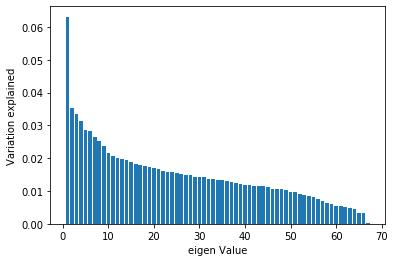

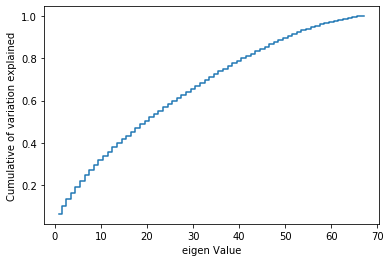

In [278]:
# Dimensionality reduction using PCA
pca = PCA(n_components=X.shape[1])
pca.fit(x_train)
print(pca.explained_variance_ratio_)

plt.bar(list(range(1,X.shape[1]+1)),pca.explained_variance_ratio_, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

plt.step(list(range(1,X.shape[1]+1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cumulative of variation explained')
plt.xlabel('eigen Value')
plt.show()

- We observe that first 5 principal components are more important than the other.
- Also, the first 30 principal components explain around 60% of the variance.

In [279]:
# Target balancing using SMOTE
print('Imbalanced Target vector:\n', y_train.value_counts())
smote = SMOTE(random_state=7)
x_train,y_train = smote.fit_resample(x_train,y_train)
print('\nBalanced Target vector:\n', y_train.value_counts())

Imbalanced Target vector:
 1.0    1018
0.0      78
Name: Pass/Fail, dtype: int64

Balanced Target vector:
 0.0    1018
1.0    1018
Name: Pass/Fail, dtype: int64


Classification accuracy of the train data : 0.8354616895874263
Classification accuracy of the test data : 0.7409766454352441

 Classification report:
              precision    recall  f1-score   support

         0.0       0.11      0.50      0.18        26
         1.0       0.96      0.76      0.85       445

    accuracy                           0.74       471
   macro avg       0.53      0.63      0.51       471
weighted avg       0.92      0.74      0.81       471



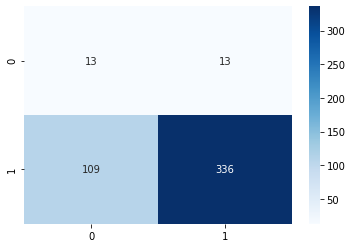

In [280]:
# We recheck the results of the Logistic Regression model using the balanced data
model_lr_bal = LogisticRegression(solver="liblinear")
model_lr_bal.fit(x_train, y_train)

y_predict = model_lr_bal.predict(x_test)

print('Classification accuracy of the train data :', model_lr_bal.score(x_train, y_train))
print('Classification accuracy of the test data :', model_lr_bal.score(x_test, y_test))

conf_mat = metrics.confusion_matrix(y_test,y_predict)
df_conf_mat = pd.DataFrame(conf_mat)
sns.heatmap(df_conf_mat,annot=True,cmap='Blues',fmt='g')
print('\n Classification report:')
print(metrics.classification_report(y_test,y_predict,digits=2))

Comparing the confusion matrices before and after the target balancing, we can say that in the later case:
1. True Positives (TP) is decreased,
2. True Negatives (TN) is slightly increased,
3. False Positives (FP) is slightly decreased, - Type I error
4. False Negatives (FN) is drastically increased - Type II error

95.0 confidence interval 89.5% and 93.1%


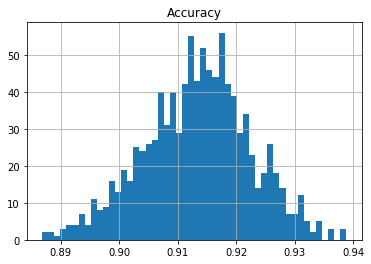

In [281]:
# Bootstrap sampling
n_iter = 1000

accuracy = []
for i in range(n_iter):
    data_train = resample(data_raw,n_samples=int(data_raw.shape[0]*0.7))
    data_test_indices = np.array([x for x in data_raw.index.values if not x in data_train.index.values])
    data_test  = data_raw.iloc[data_test_indices]
    
    x_train_resample = data_train.drop(['Pass/Fail'],axis=1).apply(zscore)
    y_train_resample = data_train['Pass/Fail']
    x_test_resample  = data_test.drop(['Pass/Fail'],axis=1).apply(zscore)
    y_test_resample  = data_test['Pass/Fail']
    
    model_lr = LogisticRegression()
    model_lr.fit(x_train_resample, y_train_resample)

    y_predict_resample = model_lr.predict(x_test_resample)
    out_of_sample_accuracy  = model_lr.score(x_test_resample, y_test_resample)
    accuracy.append(out_of_sample_accuracy)

dataframe_temp = pd.DataFrame(accuracy)
dataframe_temp.columns = ['Accuracy']
dataframe_temp.hist(bins=50)
alpha = 0.95                             
p = ((1.0-alpha)/2.0) * 100           
lower = max(0.0, np.percentile(accuracy, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(accuracy, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

- From the above results, we can say with 95% confidence that, using the Logitic Regression model we can achieve an accuracy between 89.8% and 93.1%.

In [282]:
# We apply all the above steps for the  Random Forest Classifier
pipe_rf = Pipeline([('pca', PCA(n_components=30)), ('rf', RandomForestClassifier(n_estimators=50, random_state=1))]) 
pipe_rf.fit(x_train, y_train) 

print('Classification accuracy of the train data :',pipe_rf.score(x_train, y_train))
print('Classification accuracy of the test data :',pipe_rf.score(x_test, y_test))

Classification accuracy of the train data : 1.0
Classification accuracy of the test data : 0.8980891719745223


- We observe that Random Forest Classifier model is overfitted.

RandomForestClassifier(max_depth=15, n_estimators=300)
Classification accuracy of the train data : 1.0
Classification accuracy of the test data : 0.8895966029723992

 Classification report:
              precision    recall  f1-score   support

         0.0       0.14      0.19      0.16        26
         1.0       0.95      0.93      0.94       445

    accuracy                           0.89       471
   macro avg       0.55      0.56      0.55       471
weighted avg       0.91      0.89      0.90       471



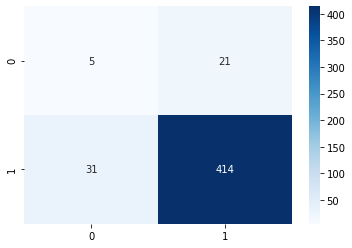

In [283]:
# Hyperparameter tuning for the Random Forest Classifier
hyperparameters = {"max_depth":[ 3, 4, 5, 6, 8, 10, 12, 15],"n_estimators" : range(50, 400, 50)}
grid_search_rf = GridSearchCV(RandomForestClassifier(),hyperparameters,n_jobs=4,scoring="accuracy",cv=kfold_stratified)
best_rf_model = grid_search_rf.fit(x_train,y_train)

rf_clsf_best = best_rf_model.best_estimator_
rf_clsf_best.fit(x_train, y_train)
print(rf_clsf_best)
y_pred_best_rf = rf_clsf_best.predict(x_test)

print('Classification accuracy of the train data :', rf_clsf_best.score(x_train, y_train))
print('Classification accuracy of the test data :', rf_clsf_best.score(x_test, y_test))

conf_mat = metrics.confusion_matrix(y_test,y_pred_best_rf)
df_conf_mat = pd.DataFrame(conf_mat)
sns.heatmap(df_conf_mat,annot=True,cmap='Blues',fmt='g')
print('\n Classification report:')
print(metrics.classification_report(y_test,y_pred_best_rf,digits=2))

From the confusion matrix we can say that:
1. True Positives (TP): we correctly predicted 412 pass category instances
2. True Negatives (TN): we correctly predicted only 7 failed category instances
3. False Positives (FP): we incorrectly predicted 19 pass category instances - Type I error
4. False Negatives (FN): we incorrectly predicted 33 negative category instances - Type II error

In [284]:
# We apply all the above steps for the Xg boost method 
pipe_xgb = Pipeline([('pca', PCA(n_components=30)), ('xg',XGBClassifier(random_state=1))]) 
pipe_xgb.fit(x_train, y_train) 

print('Classification accuracy of the train data :',pipe_rf.score(x_train, y_train))
print('Classification accuracy of the test data :',pipe_rf.score(x_test, y_test))

Classification accuracy of the train data : 1.0
Classification accuracy of the test data : 0.8980891719745223


- Agsin, we observe thatXg boost method is also overfitted.

XGBClassifier(max_depth=12, n_estimators=300)
Classification accuracy of the train data : 1.0
Classification accuracy of the test data : 0.8067940552016986

 Classification report:
              precision    recall  f1-score   support

         0.0       0.11      0.35      0.17        26
         1.0       0.96      0.83      0.89       445

    accuracy                           0.81       471
   macro avg       0.53      0.59      0.53       471
weighted avg       0.91      0.81      0.85       471



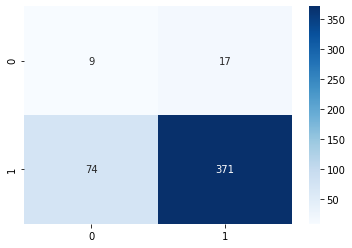

In [285]:
# Hyperparameter tuning for the Xg boost method 
hyperparameters = {"max_depth":[ 3, 4, 5, 6, 8, 10, 12, 15],"n_estimators" : range(50, 400, 50)}
grid_search_xgb = GridSearchCV(XGBClassifier(),hyperparameters,n_jobs=4,scoring="accuracy",cv=kfold_stratified)
best_xgb_model = grid_search_xgb.fit(x_train,y_train)

xg_clsf_best = best_xgb_model.best_estimator_
xg_clsf_best.fit(x_train, y_train)
print(xg_clsf_best)
y_pred_best_xg = xg_clsf_best.predict(x_test)

print('Classification accuracy of the train data :', xg_clsf_best.score(x_train, y_train))
print('Classification accuracy of the test data :', xg_clsf_best.score(x_test, y_test))

conf_mat = metrics.confusion_matrix(y_test,y_pred_best_xg)
df_conf_mat = pd.DataFrame(conf_mat)
sns.heatmap(df_conf_mat,annot=True,cmap='Blues',fmt='g')
print('\n Classification report:')
print(metrics.classification_report(y_test,y_pred_best_xg,digits=2))

From the confusion matrix we can say that:
1. True Positives (TP): we correctly predicted 371 pass category instances
2. True Negatives (TN): we correctly predicted only 9 failed category instances
3. False Positives (FP): we incorrectly predicted 17 pass category instances - Type I error
4. False Negatives (FN): we incorrectly predicted 74 negative category instances - Type II error

Here, we note that the target of the machine learning implementation on the given dataset is to detect the failure of the components. Hence, for a given model, the 'Recall' metric of the class '0' is more important than the over all accuracy obtained by the model. Due to this reason, we select the Logistic Regression model that is trained on the data with the target balance as the best model because it has best recall rate among all the models that are used here on the data.

In [286]:
# Pickle the best model
filename = 'LogisticRegression_model.sav'
pickle.dump(model_lr_bal, open(filename, 'wb'))

In [287]:
# Load the prediction data
data_future_predictions = pd.read_excel('Future_predictions.xlsx')
print(data_future_predictions.size)
print(data_future_predictions.shape)

10638
(18, 591)


In [288]:
time_data = data_future_predictions['Time']
data_future_predictions = data_future_predictions.drop(['Time'],axis=1)

In [289]:
data_future_predictions.isna().sum()

0      0
1      0
2      0
3      0
4      0
      ..
585    0
586    1
587    1
588    1
589    1
Length: 590, dtype: int64

In [290]:
len(data_future_predictions.columns[data_future_predictions.isna().mean()>0.50])

24

In [291]:
drop_missing_val_cols = data_future_predictions.columns[data_future_predictions.isna().mean()>=0.50]
print(drop_missing_val_cols)
data_future_predictions = data_future_predictions.drop(drop_missing_val_cols,axis=1)

Index([ 72,  73,  85, 109, 110, 111, 157, 158, 220, 244, 245, 246, 292, 293,
       345, 346, 358, 382, 383, 384, 492, 516, 517, 518],
      dtype='object')


In [292]:
# Impute the null values using the median values in the respective column
columns = data_future_predictions.columns
imputer = SimpleImputer(missing_values = np.nan, strategy ='median',copy=False)
data_future_predictions = pd.DataFrame(imputer.fit_transform(data_future_predictions))

In [293]:
corr_mat = data_future_predictions.corr()
threshold = 0.7
drop_corr_cols = [(corr_mat.columns.values[j]) for j in range(len(corr_mat.columns)-1) for i in range(len(corr_mat.index.values)-1) if i!=j and corr_mat.iloc[i,j]>threshold]
drop_corr_cols = set(drop_corr_cols)
len(drop_corr_cols)

370

In [294]:
data_future_predictions = data_future_predictions.drop(drop_corr_cols,axis=1)
data_future_predictions.head()

,0,1,5,6,7,8,9,10,11,13,...,514,519,521,522,524,538,546,547,557,565
0,3030.93,2564.00,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,0.0,...,0.0,0.0078,7.116,1.0616,75.752,265.090,533.8500,2.1113,82.8602,82.0989
1,3095.78,2465.14,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,0.0,...,0.0,0.0078,7.116,1.3526,74.640,265.090,535.0164,2.4335,208.2045,208.2045
2,2932.61,2559.94,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,0.0,...,0.0,0.0078,7.116,0.7942,74.654,267.064,535.0245,2.0293,82.8602,82.8602
3,2988.72,2479.90,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,0.0,...,0.0,0.0078,7.116,1.1650,72.442,268.228,530.5682,2.0253,73.8432,73.8432
4,3032.24,2502.87,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,0.0,...,0.0,0.0078,7.116,1.4636,79.156,265.090,532.0155,2.0275,82.8602,73.8432


In [295]:
data_future_predictions['Time'] = time_data

data_future_predictions['year'] = pd.DatetimeIndex(data_future_predictions['Time']).year
data_future_predictions['month'] = pd.DatetimeIndex(data_future_predictions['Time']).month
data_future_predictions['date'] = pd.DatetimeIndex(data_future_predictions['Time']).day
data_future_predictions['week_day'] = pd.DatetimeIndex(data_future_predictions['Time']).weekday
data_future_predictions['hour'] = pd.DatetimeIndex(data_future_predictions['Time']).hour
data_future_predictions['min'] = pd.DatetimeIndex(data_future_predictions['Time']).minute

In [296]:
data_future_predictions.columns

Index([         0,          1,          5,          6,          7,          8,
                9,         10,         11,         13,
       ...
              547,        557,        565,     'Time',     'year',    'month',
           'date', 'week_day',     'hour',      'min'],
      dtype='object', length=203)

In [297]:
data_future_predictions = data_future_predictions.drop(['Time','year'],axis=1)

In [298]:
data_future_predictions = data_future_predictions.drop(data_future_predictions.iloc[:,:-6].std()[data_future_predictions.iloc[:,:-6].std() < 0.5].index.values[0:134], axis=1)
data_future_predictions.head()

,0,1,6,14,15,24,28,37,41,71,...,538,546,547,557,565,month,date,week_day,hour,min
0,3030.93,2564.00,97.6133,7.9558,414.8710,751.00,64.2333,66.3141,4.515,84.0793,...,265.090,533.8500,2.1113,82.8602,82.0989,7,19,5,11,55
1,3095.78,2465.14,102.3433,10.1548,414.7347,-1640.25,68.4222,64.9193,2.773,82.3494,...,265.090,535.0164,2.4335,208.2045,208.2045,7,19,5,12,32
2,2932.61,2559.94,95.4878,9.5157,416.7075,-1916.50,67.1333,65.8389,5.434,84.7681,...,267.064,535.0245,2.0293,82.8602,82.8602,7,19,5,13,17
3,2988.72,2479.90,104.2367,9.6052,422.2894,-1657.25,62.9333,65.1951,1.279,70.2289,...,268.228,530.5682,2.0253,73.8432,73.8432,7,19,5,14,43
4,3032.24,2502.87,100.3967,10.5661,420.5925,117.00,62.8333,66.1542,2.209,65.8417,...,265.090,532.0155,2.0275,82.8602,73.8432,7,19,5,15,22


In [299]:
# load the best model 
load_model_lr = pickle.load(open(filename, 'rb'))
y_predict = load_model_lr.predict(data_future_predictions)


In [300]:
data_future_predictions['Pass_fail_predict'] = y_predict
data_future_predictions['Pass_fail_predict'].value_counts()

1.0    18
Name: Pass_fail_predict, dtype: int64

In [301]:
# Prediction results
data_future_predictions

,0,1,6,14,15,24,28,37,41,71,...,546,547,557,565,month,date,week_day,hour,min,Pass_fail_predict
0,3030.93,2564.00,97.6133,7.9558,414.8710,751.00,64.2333,66.3141,4.515,84.0793,...,533.8500,2.1113,82.8602,82.0989,7,19,5,11,55,1.0
1,3095.78,2465.14,102.3433,10.1548,414.7347,-1640.25,68.4222,64.9193,2.773,82.3494,...,535.0164,2.4335,208.2045,208.2045,7,19,5,12,32,1.0
2,2932.61,2559.94,95.4878,9.5157,416.7075,-1916.50,67.1333,65.8389,5.434,84.7681,...,535.0245,2.0293,82.8602,82.8602,7,19,5,13,17,1.0
3,2988.72,2479.90,104.2367,9.6052,422.2894,-1657.25,62.9333,65.1951,1.279,70.2289,...,530.5682,2.0253,73.8432,73.8432,7,19,5,14,43,1.0
4,3032.24,2502.87,100.3967,10.5661,420.5925,117.00,62.8333,66.1542,2.209,65.8417,...,532.0155,2.0275,82.8602,73.8432,7,19,5,15,22,1.0
5,2946.25,2432.84,100.3967,8.6617,414.2426,193.75,62.3778,66.2949,3.024,70.3707,...,534.2091,2.3236,44.0077,44.0077,7,19,5,17,53,1.0
6,3030.27,2430.12,102.3433,9.0350,415.8852,580.25,60.8000,66.2237,3.978,83.4997,...,541.9036,2.4229,82.8602,44.0077,7,19,5,19,44,1.0
7,3058.88,2690.15,106.2400,13.6872,408.4017,-737.00,67.3000,65.0665,2.671,57.0841,...,493.0054,2.2008,95.0310,95.0310,7,19,5,19,45,1.0
8,2967.68,2600.47,106.2400,12.6837,417.6009,622.75,62.8000,66.3322,3.217,74.3992,...,535.1818,2.2170,111.6525,111.6525,7,19,5,20,24,1.0
9,3016.11,2428.37,106.2400,12.4278,413.3677,873.75,67.0333,65.0665,2.671,65.5040,...,533.4200,2.2598,90.2294,90.2294,7,19,5,21,35,1.0


<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;">  6. Conclusion and improvisation

Conclusions:
   - the given dataset is acquired from certain critical and also non-crtical channels in the semiconductor manufacturing process, 
   - the target is the failure detection of the components,
   - the challenge in preparing the given dataset for machine learning implementation lies in reducing the dimensionality,
   - we use several statstical concepts to reduce the dimensionality of the data from 591 features to 67 features,
   - firstly, we applied Logistic Regression to model the data,
   - we observe that the obtained 'Recall' metric of the class '0' by applying the Logistic Regression model to the raw data is very low even  
     after the CV and hyper-parameter tuning, 
   - however, the 'Recall' metric of the class '0' is improved after performing target balacing,
   - the accuracy achieved with 95% confidence level is between 89.8% and 93.1%,
   - we then apply CV and hyper-parameter tuning for the RandomForest clasifier and the Xgboost model,
   - however, the true negativity rate is not improved,
   - finally, we perform predictions on the unseen dataset using Logistic Regression model.
 
Recomendations:
   - we can improve the data by removing the noise based on domain knowledge combined with the statistical methods, 
   - the quality and the quantity of the data, that is the data channels and the number of observations, needs to be improved inorder to  
     address the target imbalance issue present in the data.